# Project: Deep Autoencoders for Image Reconstruction and Denoising on MNIST & FMNIST

**Students:**

*Jorge Barcenilla*

*Álex Sánchez Zurita*

*Santiago Prieto Núñez*

## 1. Introduction

This notebook implements and evaluates deep autoencoders (AEs) on the MNIST and Fashion-MNIST (FMNIST) datasets.  
The project is divided into two main parts:

### Standard Autoencoder
We will build and train a standard autoencoder with dense layers.  
We will perform a comparative analysis by:
- Varying the network depth (3 vs. 5 layers for both encoder and decoder).
- Studying the influence of the latent dimension size (15, 30, 50, 100).
- Implementing ($L_1$) (Lasso) regularization on the encoder's output to induce sparsity.

### Denoising Autoencoder (DAE)
Using the best-performing architecture from Part 1, we will implement a denoising autoencoder.  
We will:
- Inject additive zero-mean Gaussian noise into the input images.
- Analyze the DAE's reconstruction performance as a function of the noise variance.  

Performance will be quantified using the Peak Signal-to-Noise Ratio (PSNR) and qualitative visual comparisons of the reconstructed images.

## 2. Setup and Data Preparation

### 2.1. Import Libraries

In [8]:
# --- Placeholder for Library Imports ---
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd

### 2.2. Helper Functions

In [9]:
# --- Placeholder for Helper Functions ---

def psnr_metric(originals, reconstructed):
    """Calculates the average PSNR for a batch of images."""
    originals_np = originals.cpu().numpy()
    reconstructed_np = reconstructed.cpu().numpy()

    batch_psnr = 0
    for i in range(originals_np.shape[0]):
        # Ensure data range is [0, 1] for PSNR calculation
        data_range = 1.0
        batch_psnr += psnr(originals_np[i], reconstructed_np[i], data_range=data_range)
    return batch_psnr / originals_np.shape[0]

def add_gaussian_noise(images, variance):
    """Adds zero-mean Gaussian noise to images."""
    noise = torch.randn_like(images) * (variance**0.5)
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0.0, 1.0) # Clamp to valid image range

def plot_reconstructions(originals, reconstructed, n=10, title="Reconstructions"):
    """Plots original vs. reconstructed images."""
    plt.figure(figsize=(20, 4))
    plt.suptitle(title, fontsize=16)
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(originals[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0: ax.set_title("Original")

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0: ax.set_title("Reconstructed")
    plt.show()

# (A DAE-specific plot function will be defined in Part 2)

### 2.3. Load and Prepare Datasets

In [10]:
# --- Placeholder for Data Loading ---
BATCH_SIZE = 128

# Transformation: ToTensor normalizes to [0, 1], Lambda flattens
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))
])

# MNIST
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)

# FMNIST
fmnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fmnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
fmnist_train_loader = DataLoader(fmnist_train, batch_size=BATCH_SIZE, shuffle=True)
fmnist_test_loader = DataLoader(fmnist_test, batch_size=BATCH_SIZE, shuffle=False)

## 3. Part 1: Standard Autoencoder (AE)


### 3.1. Model Definition

We'll create a flexible Autoencoder class that can build 3-layer or 5-layer (encoder/decoder) models based on initialization parameters.  
The forward method will return both the reconstruction and the latent vector \(E\) for the \(L_1\) penalty.


In [11]:
# --- Placeholder for AE Model Class ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=30, num_layers=3):
        super(Autoencoder, self).__init__()

        # --- Encoder ---
        encoder_layers = []
        if num_layers == 3:
            encoder_layers.extend([
                nn.Linear(input_dim, 256),
                nn.ReLU(),
                nn.Linear(256, latent_dim),
            ])
        elif num_layers == 5:
            encoder_layers.extend([
                nn.Linear(input_dim, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, latent_dim),
            ])
        self.encoder = nn.Sequential(*encoder_layers)

        # --- Decoder ---
        decoder_layers = []
        if num_layers == 3:
            decoder_layers.extend([
                nn.Linear(latent_dim, 256),
                nn.ReLU(),
                nn.Linear(256, input_dim),
            ])
        elif num_layers == 5:
            decoder_layers.extend([
                nn.Linear(latent_dim, 256),
                nn.ReLU(),
                nn.Linear(256, 512),
                nn.ReLU(),
                nn.Linear(512, input_dim),
            ])
        # Sigmoid activation to ensure output is in [0, 1]
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        latent_E = self.encoder(x)
        reconstruction = self.decoder(latent_E)
        return reconstruction, latent_E



### 3.2. Training and Evaluation Loops

Define functions to handle one epoch of training and one epoch of evaluation.  
The training loop must accommodate the \(L_1\) (Lasso) penalty.



In [38]:
class Extended_Autoencoder(Autoencoder):
    def __init__(self, input_dim, latent_dim, num_layers, epoch, l1=0.0, lr=1e-3):
        super().__init__(input_dim, latent_dim, num_layers)

        # Setup device (CUDA or CPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        self.to(device)

        # model variables
        self.lambda_l1 = l1
        self.lr = lr
        self.epoch = epoch
        self.device = device

        # model tools
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.criterion = nn.BCELoss()   # Using BCE as reconstruction loss, as inputs are in [0, 1]

        # evaluation data
        self.loss_during_tr = []
        self.loss_during_val = []
        self.psnr_during_val = []
        self.loss_during_test = 0
        self.psnr_during_test = 0
        self.psnr_during_noise_test = 0
        self.mean_train_time = 0        # mean train time of all epoch

    def train_loop(self, dataloader, verbose=False, 
                   validate=True, val_dataloader=None, 
                   add_gaussian_noise=False,
                   noise_var = 0.0):
        self.train()
        epoch_times = []    # time of each epoch
        
        # run the algorithm for n epoch
        for e in range(self.epoch):
            # evaluation data
            epoch_total_loss = 0
            tik = time.time()
            # run the algorihtm with the train data
            for data, _ in dataloader:
                images = data.to(self.device)

                # add gaussian noise for the needed items
                if add_gaussian_noise:
                    noise_images = self.add_gaussian_noise_(images, noise_var)

                    # Forward pass
                    recon, latent_E = self.forward(noise_images) 
                else:
                    # Forward pass
                    recon, latent_E = self.forward(images)
                    


                # Calculate losses
                recon_loss = self.criterion(recon, images)  # recontruction 
                l1_loss = self.lambda_l1 * torch.mean(torch.abs(latent_E)) # L1 penalty on E
                loss = recon_loss + l1_loss

                # Backward pass
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()


                epoch_total_loss += loss.item()

            # validate this epoch if need
            if validate and val_dataloader != None:
                self.eval_loop(val_dataloader)
                self.train()
                self.loss_during_val.append(self.loss_during_test)
                self.psnr_during_val.append(self.psnr_during_test)
                
            epoch_times.append(time.time()-tik)

            # save the epoch data
            epoch_loss = epoch_total_loss/len(dataloader)
            self.loss_during_tr.append(epoch_loss)


            if verbose:
                print(f"epoch {e}: loss - {epoch_loss:.3f}")

        self.mean_train_time = np.mean(epoch_times)

    
    def eval_loop(self, dataloader, verbose=False,
                  add_gaussian_noise=False,
                  noise_var=0.0):
        self.eval()

        with torch.no_grad():
            # evaluation data
            epoch_total_loss = 0
            epoch_total_psnr = 0
            epoch_noise_psnr = 0    # used only in case of evaluation with noise
            # run the algorihtm with the train data
            for data, _ in dataloader:
                images = data.to(self.device)

                # Forward pass with and without noise
                recon, _ = self.forward(images)

                # Analize with gaussian noise if needed
                if add_gaussian_noise:
                    noisy_images = self.add_gaussian_noise_(images, noise_var)
                    noise_recon, _ = self.forward(noisy_images)
                    epoch_noise_psnr += self.psnr_metric_(images.view(-1, 28, 28), noise_recon.view(-1, 28, 28))

                # Calculate losses
                recon_loss = self.criterion(recon, images)  # recontruction
                batch_psnr = self.psnr_metric_(images.view(-1, 28, 28), recon.view(-1, 28, 28))

                epoch_total_loss += recon_loss.item()
                epoch_total_psnr += batch_psnr

            # save the epoch data
            epoch_loss = epoch_total_loss/len(dataloader)
            epoch_psnr = epoch_total_psnr/len(dataloader)
            self.loss_during_test = epoch_loss
            self.psnr_during_test = epoch_psnr
            self.psnr_during_noise_test = epoch_noise_psnr/len(dataloader)

            if verbose:
                print(f"Evaluation loss - {epoch_loss:.2f} PSNR - {epoch_psnr:.2f}")


    def analyze_sparsity(self, dataloader, n_samples=1000):
        """Analyze sparsity in latent representations."""
        self.eval()
        latent_vectors = []
        
        with torch.no_grad():
            samples_collected = 0
            for data, _ in dataloader:
                if samples_collected >= n_samples:
                    break
                images = data.to(self.device)
                _, latent_E = self.forward(images)
                latent_vectors.append(latent_E.cpu())
                samples_collected += images.size(0)
        
        latent_vectors = torch.cat(latent_vectors, dim=0)[:n_samples]
        
        # Calculate sparsity metrics
        zero_threshold = 1e-3
        sparsity_ratio = (torch.abs(latent_vectors) < zero_threshold).float().mean().item()
        mean_activation = torch.abs(latent_vectors).mean().item()
        
        return {
            'sparsity_ratio': sparsity_ratio,
            'mean_activation': mean_activation,
            'latent_std': latent_vectors.std().item()
        }

    # --------------------------------------------------------------------------
    # MODEL FUNCTIONS
    # --------------------------------------------------------------------------
    
    def psnr_metric_(self, originals, reconstructed):
        """Calculates the average PSNR for a batch of images."""
        originals_np = originals.cpu().numpy()
        reconstructed_np = reconstructed.cpu().numpy()

        batch_psnr = 0
        for i in range(originals_np.shape[0]):
            # Ensure data range is [0, 1] for PSNR calculation
            data_range = 1.0
            batch_psnr += psnr(originals_np[i], reconstructed_np[i], data_range=data_range)
        return batch_psnr / originals_np.shape[0]

    def add_gaussian_noise_(self, images, variance):
        """Adds zero-mean Gaussian noise to images."""
        noise = torch.randn_like(images) * (variance**0.5)
        noisy_images = images + noise
        return torch.clamp(noisy_images, 0.0, 1.0) # Clamp to valid image range

        

### 3.3. Experiment 1: Architecture & Latent Dimension Analysis

This is the main experimental loop for Part 1. We'll iterate through all combinations and store the results.


--- Starting Experiment 1: Architecture vs. Latent Dimension ---
Testing: MNIST | 3-layers | 15-dim
Using device: cuda


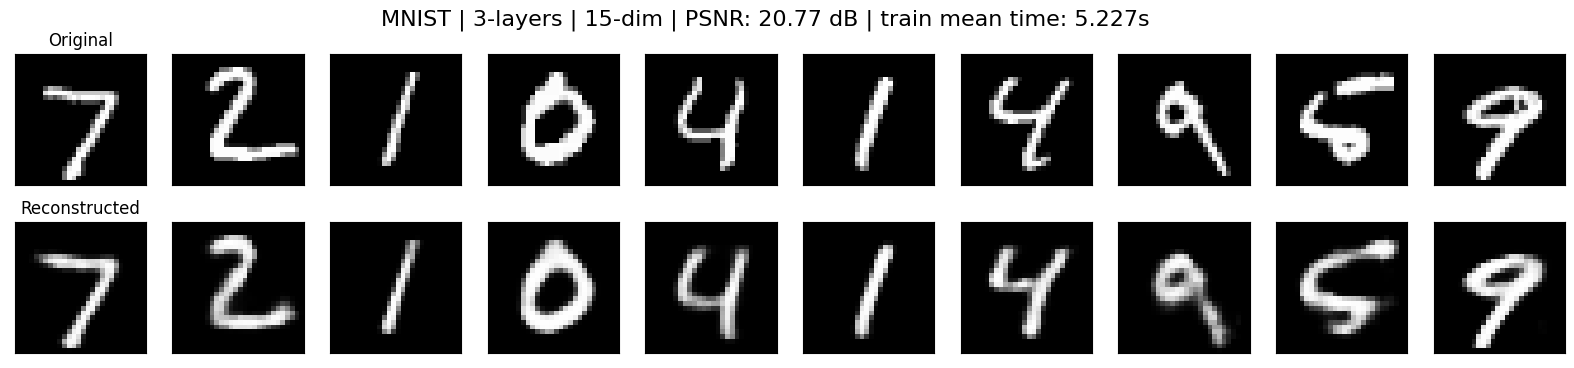

Testing: MNIST | 3-layers | 30-dim
Using device: cuda


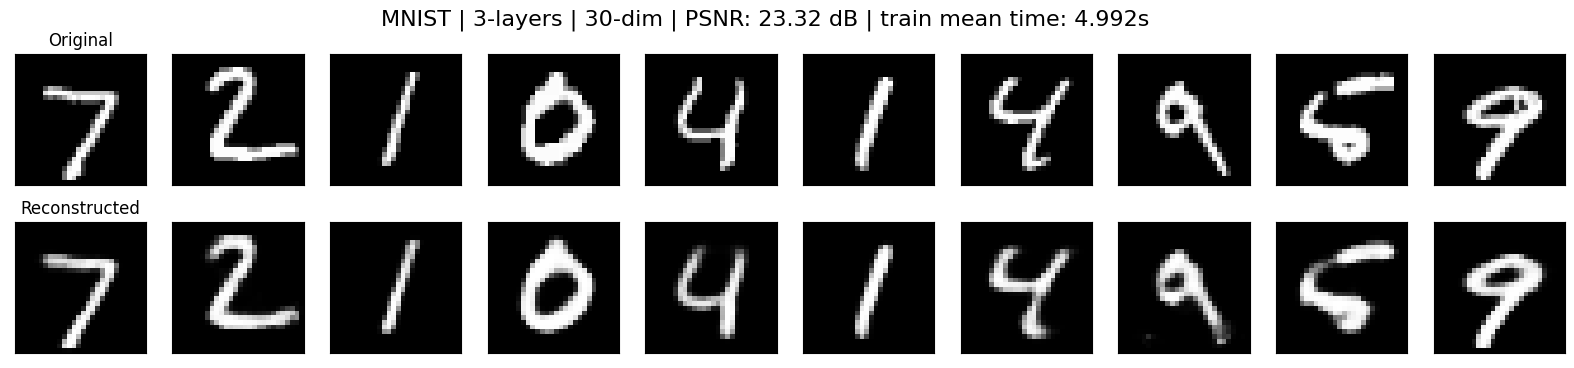

Testing: MNIST | 3-layers | 50-dim
Using device: cuda


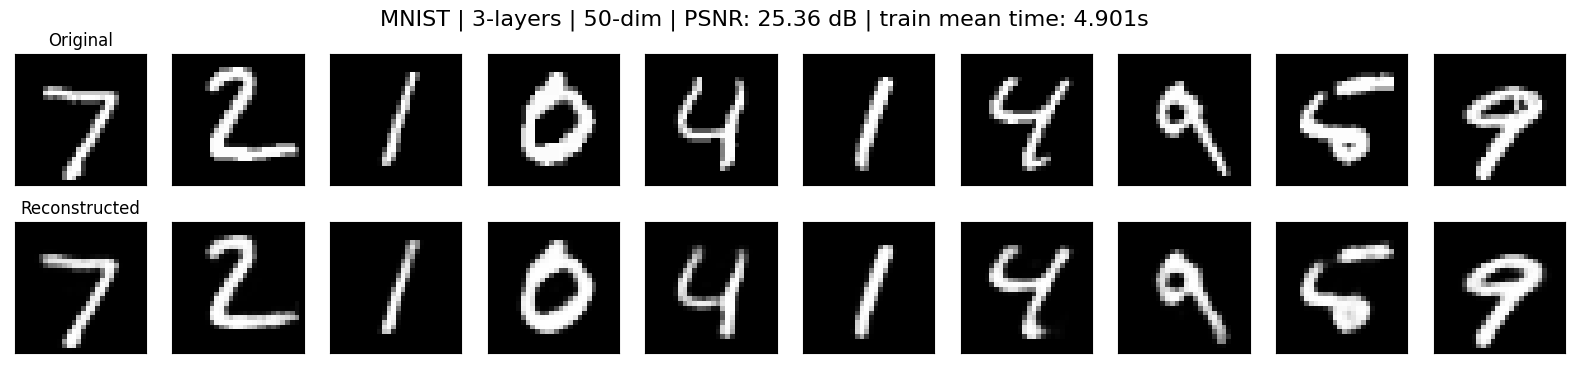

Testing: MNIST | 3-layers | 100-dim
Using device: cuda


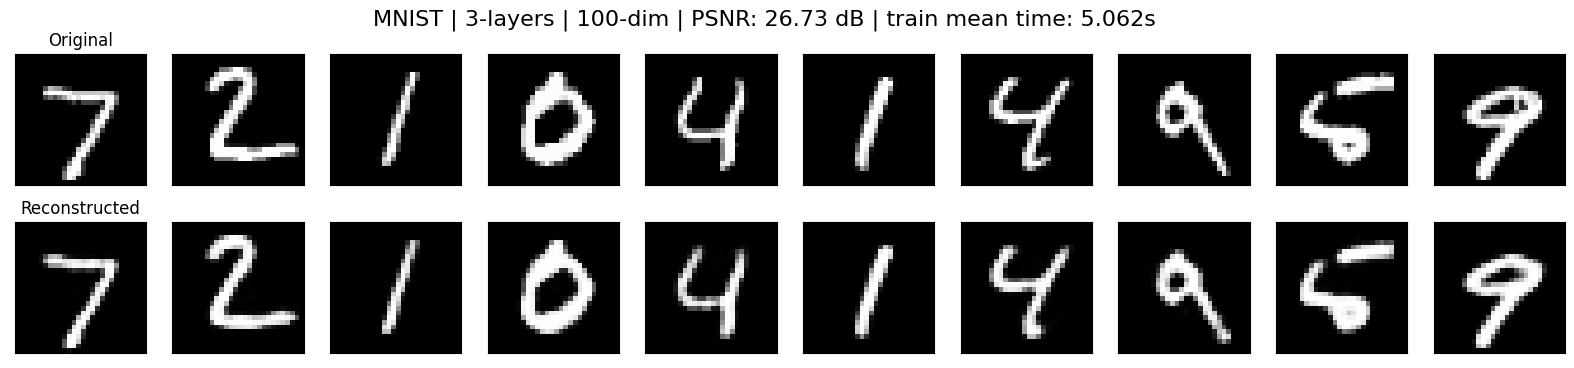

Testing: MNIST | 5-layers | 15-dim
Using device: cuda


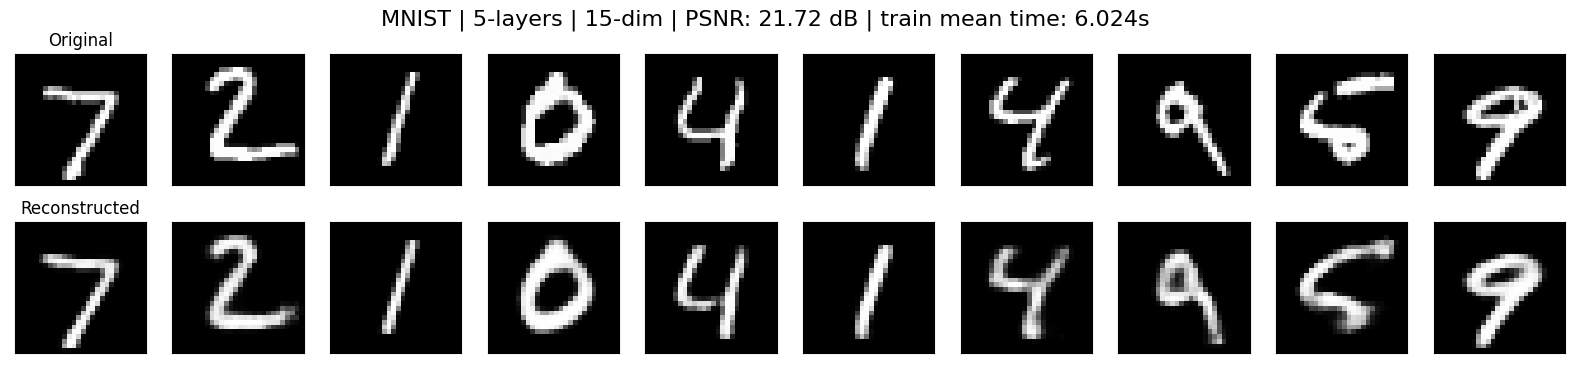

Testing: MNIST | 5-layers | 30-dim
Using device: cuda


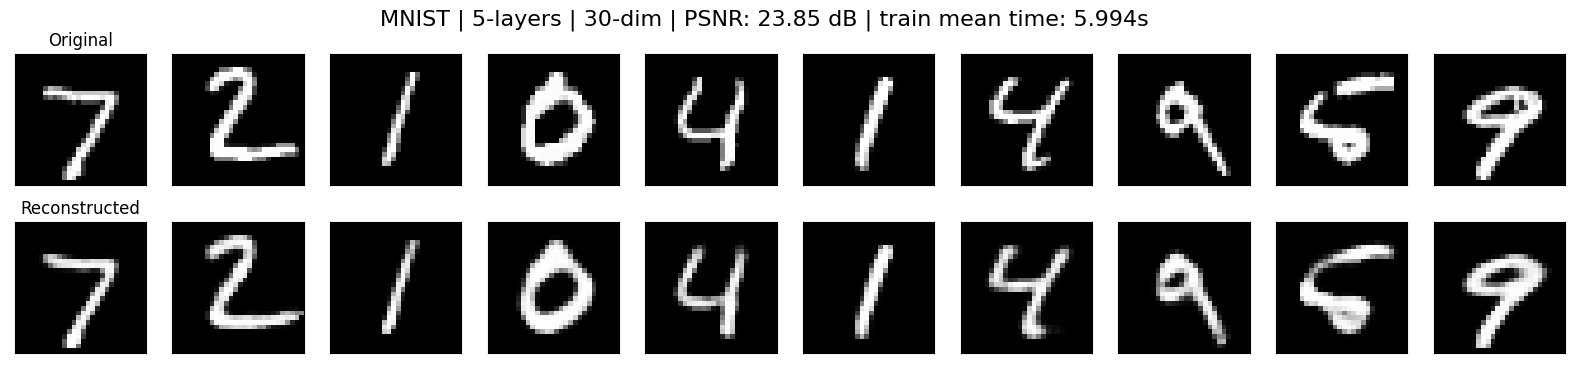

Testing: MNIST | 5-layers | 50-dim
Using device: cuda


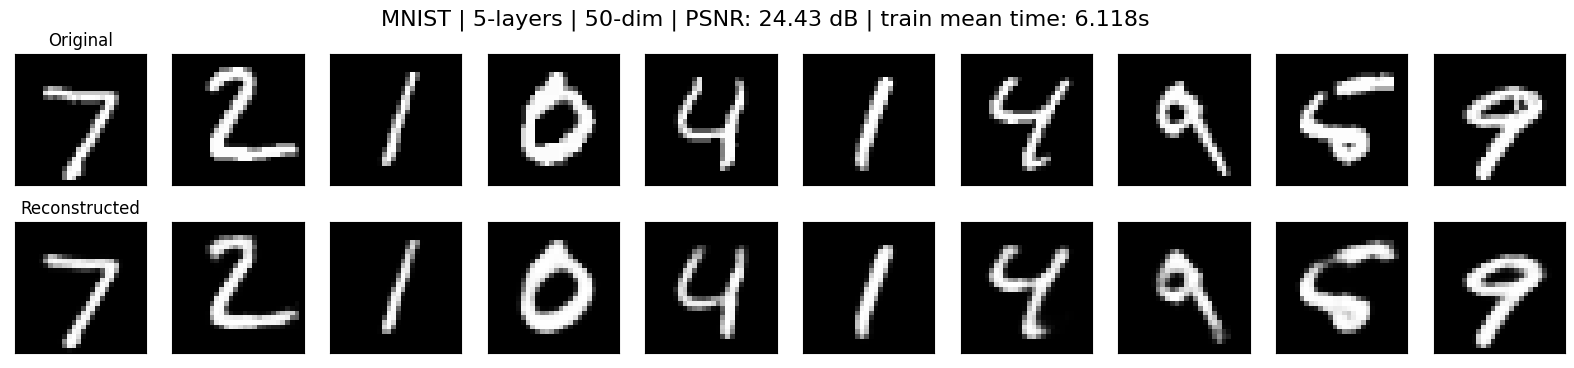

Testing: MNIST | 5-layers | 100-dim
Using device: cuda


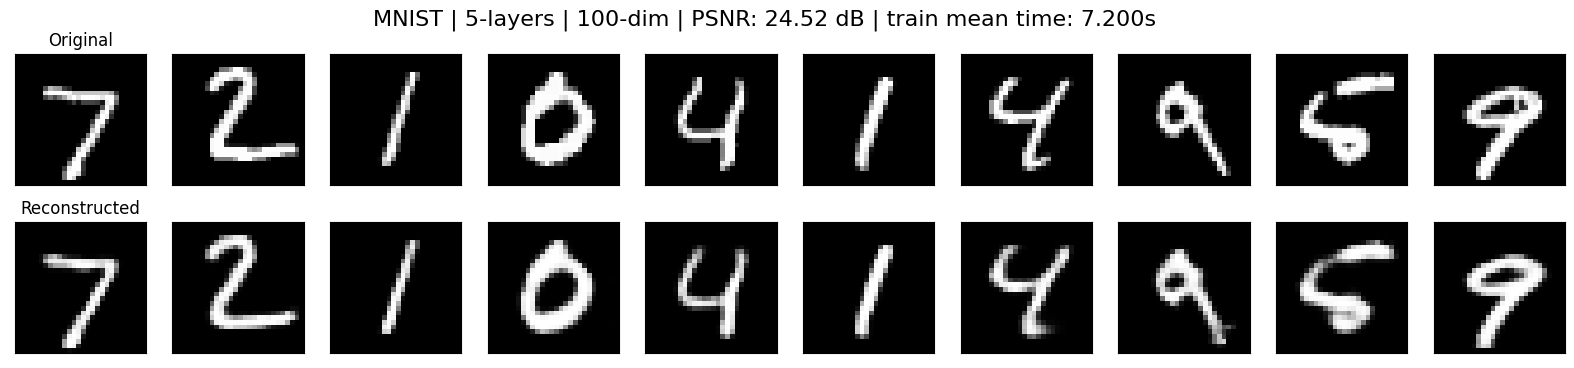

Testing: FMNIST | 3-layers | 15-dim
Using device: cuda


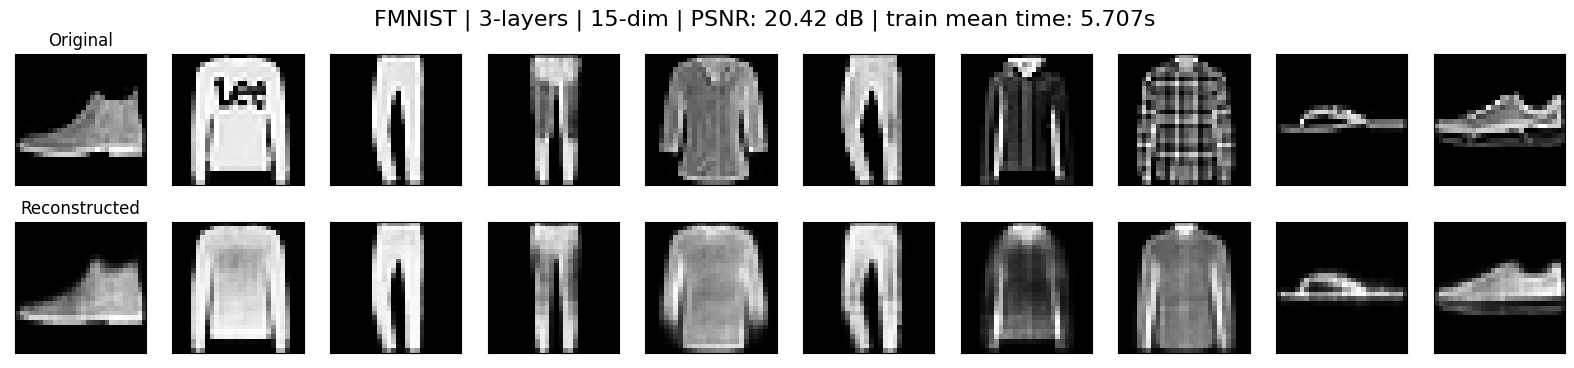

Testing: FMNIST | 3-layers | 30-dim
Using device: cuda


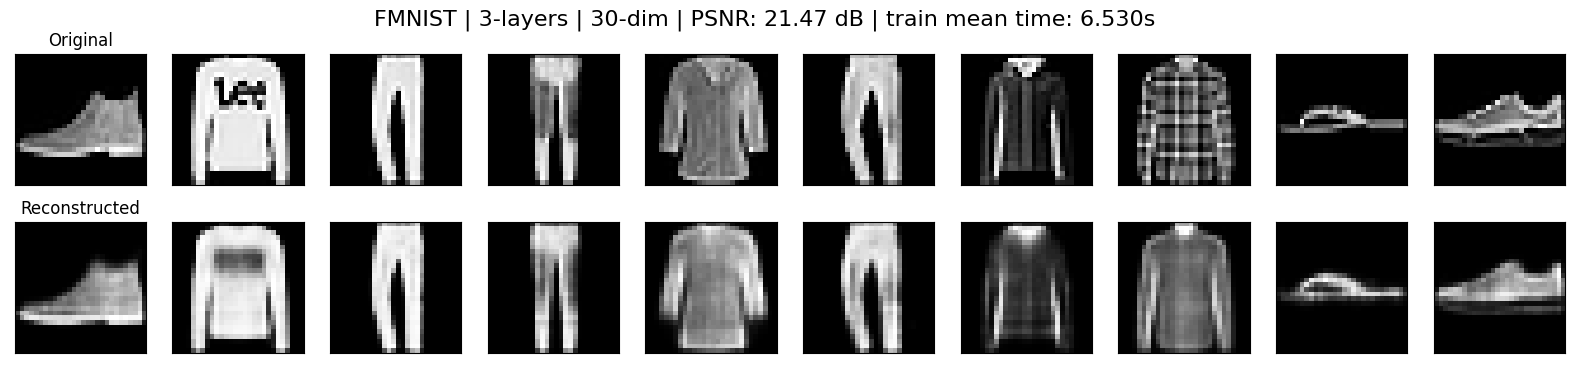

Testing: FMNIST | 3-layers | 50-dim
Using device: cuda


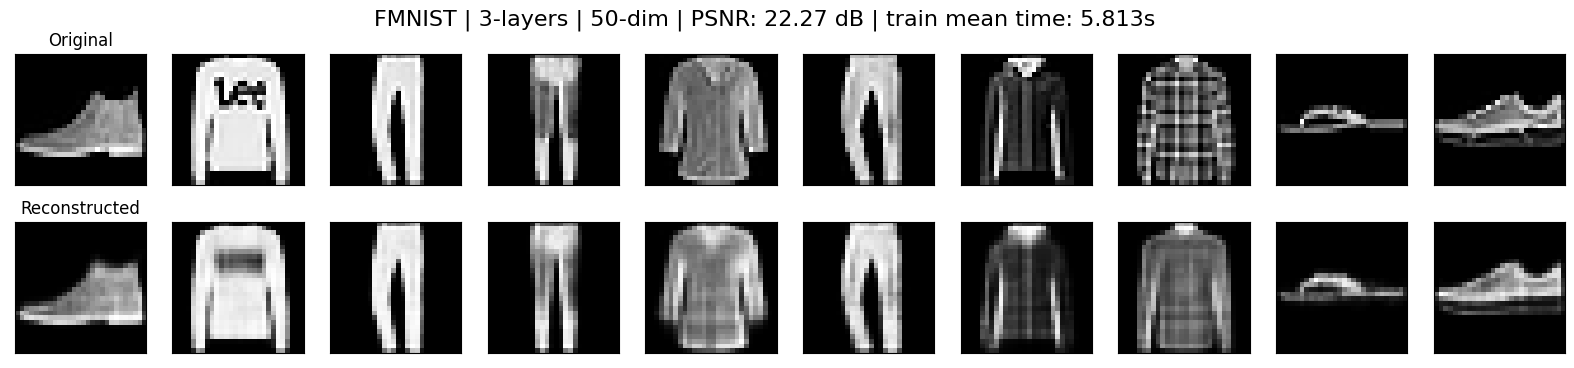

Testing: FMNIST | 3-layers | 100-dim
Using device: cuda


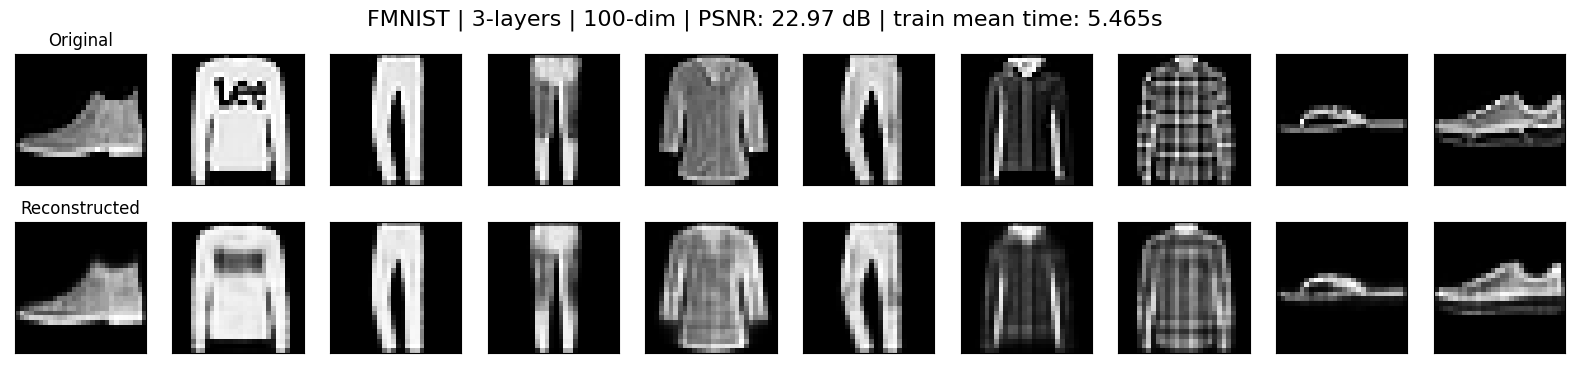

Testing: FMNIST | 5-layers | 15-dim
Using device: cuda


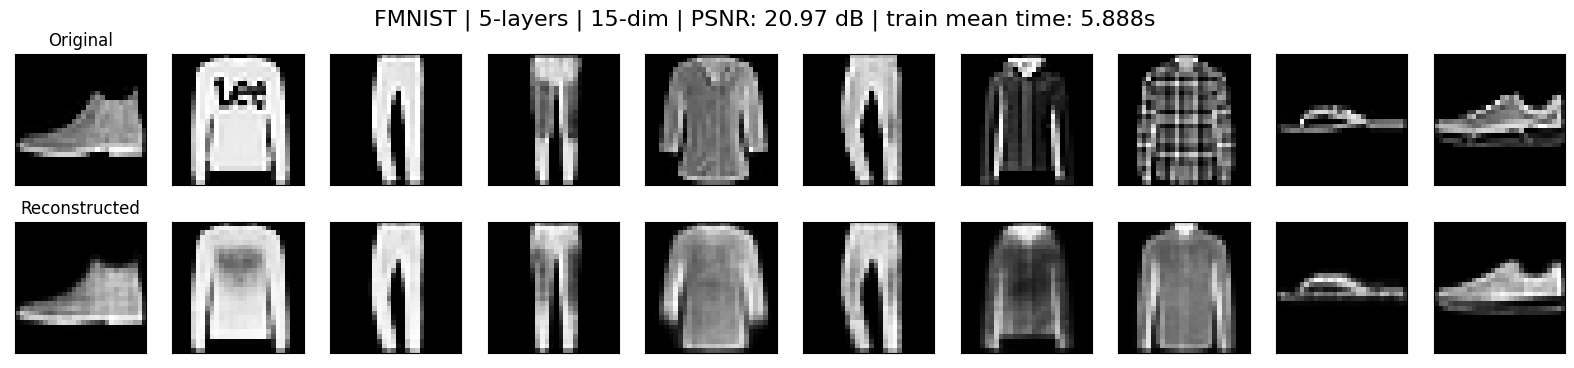

Testing: FMNIST | 5-layers | 30-dim
Using device: cuda


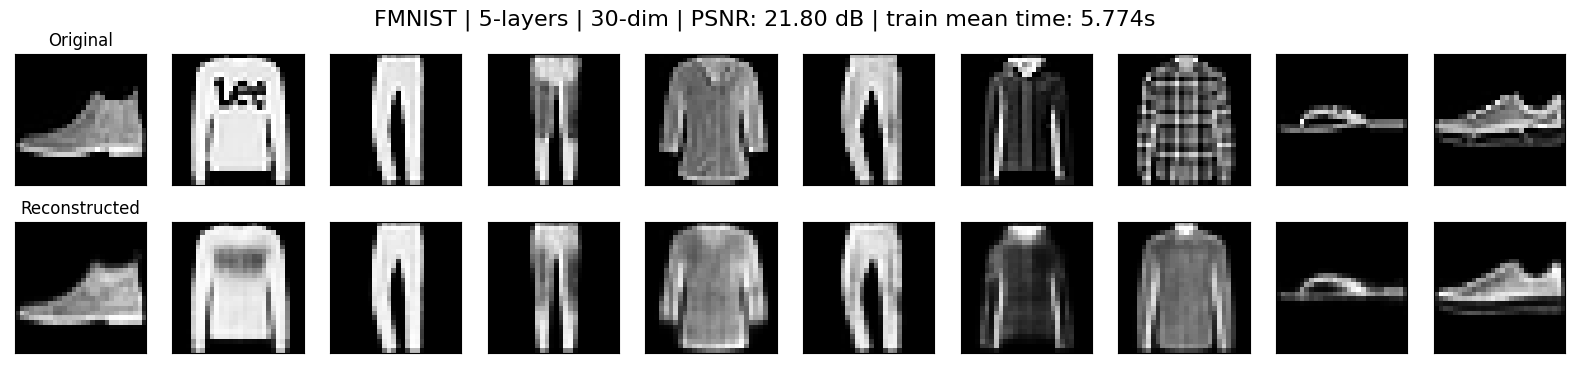

Testing: FMNIST | 5-layers | 50-dim
Using device: cuda


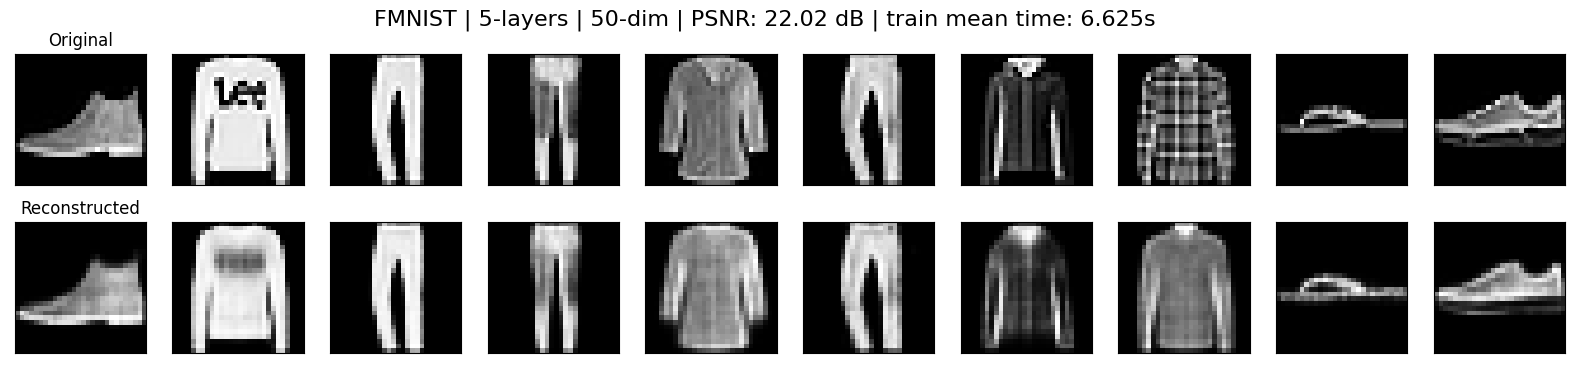

Testing: FMNIST | 5-layers | 100-dim
Using device: cuda


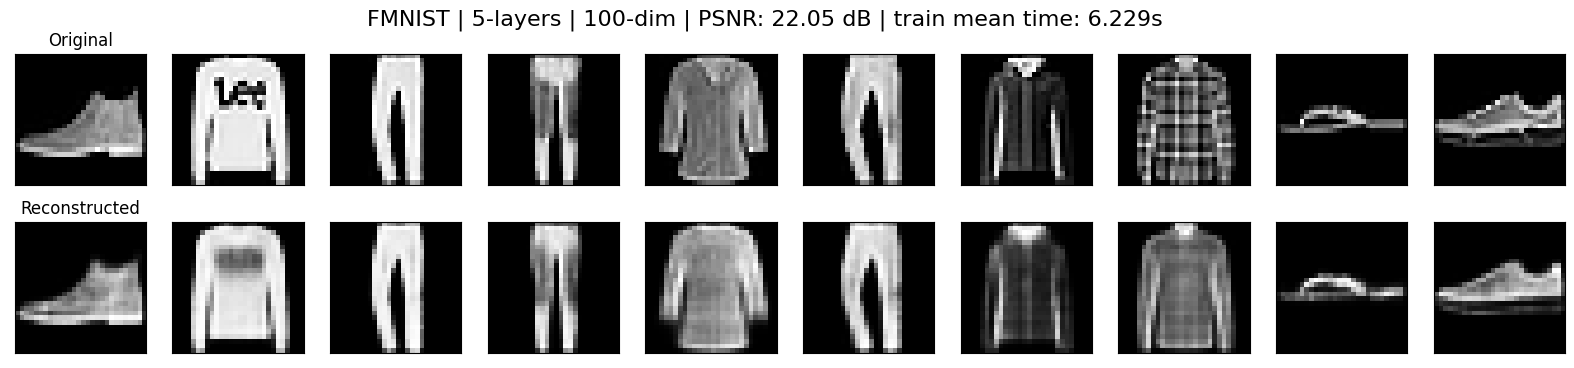

In [13]:
# --- Placeholder for Experiment 1 ---
print("--- Starting Experiment 1: Architecture vs. Latent Dimension ---")

datasets_to_test = {
    "MNIST": (mnist_train_loader, mnist_test_loader),
    "FMNIST": (fmnist_train_loader, fmnist_test_loader)
}
architectures = [3, 5] # 3-layer and 5-layer
latent_dims = [15, 30, 50, 100]
NUM_EPOCHS = 20 # (Adjust as needed)
INPUT_DIM = 784 # dimension of the images

results = []

# for each dataset 
for d_name, (train_loader, test_loader) in datasets_to_test.items():
    # for the different arquitectures configuration
    for num_layers in architectures:
        for dim in latent_dims:
            print(f"Testing: {d_name} | {num_layers}-layers | {dim}-dim")

            # create the model
            model = Extended_Autoencoder(input_dim=INPUT_DIM, latent_dim=dim, 
                                         num_layers=num_layers, epoch=NUM_EPOCHS,
                                         l1=0.0)

            # train the model
            model.train_loop(train_loader)

            # test the model
            model.eval_loop(test_loader)
            
            # get the model results
            test_loss = model.loss_during_test
            test_psnr = model.psnr_during_test

            results.append({
                "Dataset": d_name,
                "Layers": num_layers,
                "Latent Dim": dim,
                "Test Loss (BCE)": test_loss,
                "Test PSNR (dB)": test_psnr,
                "Mean train time (s)": model.mean_train_time
            })

            # Visualize results for this model
            data, _ = next(iter(test_loader))
            recon, _ = model(data.to(model.device))
            plot_reconstructions(data.cpu(), recon.cpu().detach(),
                                 title=f"{d_name} | {num_layers}-layers | {dim}-dim | PSNR: {test_psnr:.2f} dB | train mean time: {model.mean_train_time:.3f}s")


| Dataset   |   Layers |   Latent Dim |   Test Loss (BCE) |   Test PSNR (dB) |   Mean train time (s) |
|:----------|---------:|-------------:|------------------:|-----------------:|----------------------:|
| MNIST     |        3 |           15 |         0.093416  |          20.7661 |               5.22708 |
| MNIST     |        3 |           30 |         0.0783597 |          23.3192 |               4.99239 |
| MNIST     |        3 |           50 |         0.0712899 |          25.3577 |               4.90143 |
| MNIST     |        3 |          100 |         0.0680811 |          26.7313 |               5.06194 |
| MNIST     |        5 |           15 |         0.0870256 |          21.7245 |               6.02375 |
| MNIST     |        5 |           30 |         0.0761363 |          23.8532 |               5.99352 |
| MNIST     |        5 |           50 |         0.073945  |          24.4294 |               6.11809 |
| MNIST     |        5 |          100 |         0.0735617 |          24.5

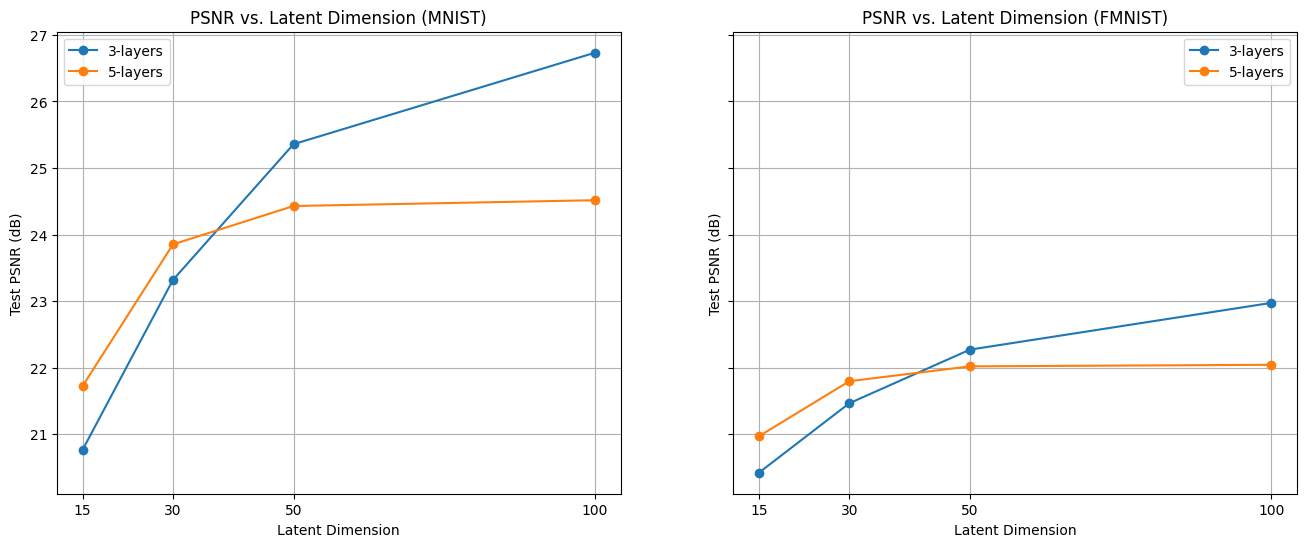

In [14]:
# --- Results Analysis (Exp 1) ---
results_df = pd.DataFrame(results)
print(results_df.to_markdown(index=False))

# Plot summary graphs (e.g., Latent Dim vs. PSNR for each arch/dataset)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
for i, d_name in enumerate(datasets_to_test.keys()):
    ax = axes[i]
    for num_layers in architectures:
        subset = results_df[(results_df['Dataset'] == d_name) & (results_df['Layers'] == num_layers)]
        ax.plot(subset['Latent Dim'], subset['Test PSNR (dB)'], 'o-', label=f'{num_layers}-layers')
    ax.set_title(f"PSNR vs. Latent Dimension ({d_name})")
    ax.set_xlabel("Latent Dimension")
    ax.set_ylabel("Test PSNR (dB)")
    ax.set_xticks(latent_dims)
    ax.legend()
    ax.grid(True)
plt.show()

With this results, the best model is the one that has 3 layers and 100 dimensions on the latent space. This means that for this specific problem, simply adding more depth (i.e., going from 3 to 5 layers) did not result in a better model.

In fact, the 5-layer model showed clear signs of stagnation on MNIST and performance degradation on the more complex FMNIST dataset (where its PSNR dropped at 100 dimensions). This suggests the 5-layer architecture may be too complex, harder to optimize, or prone to overfitting for this task.

The simpler 3-layer model proved to be more robust and scaled its performance effectively, achieving a higher PSNR on both datasets when given a sufficient latent capacity (100 dimensions).

### 3.4. Experiment 2: \(L_1\) (Lasso) Regularization on Latent Space

Based on the results from Exp 1, we select a promising architecture (e.g., 5-layer, 50-dim) and test the effect of \(L_1\) regularization on the latent vector \(E\).


--- Training with λ_L1 = 0.0 ---
Using device: cuda


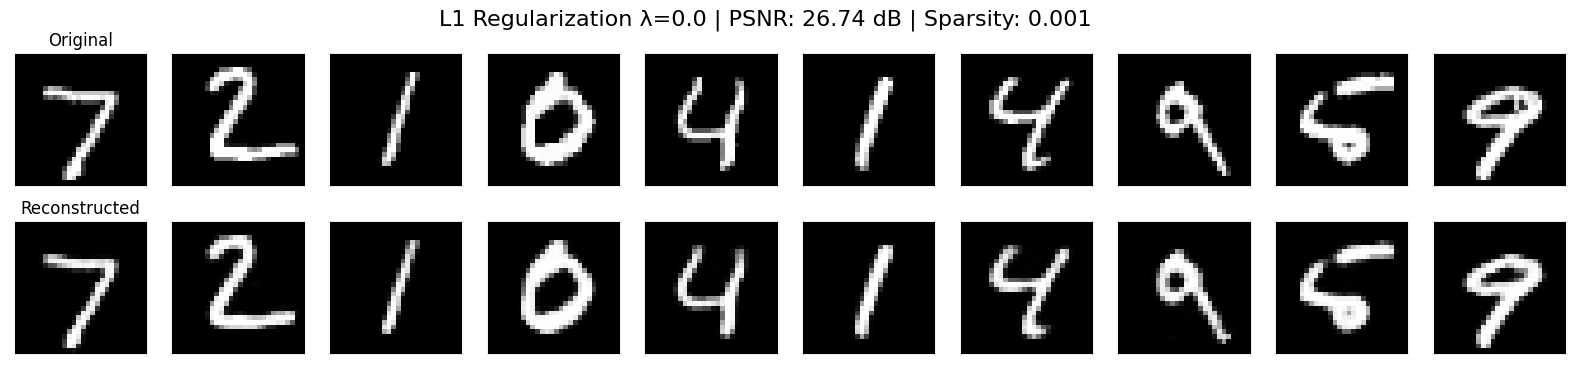

Final Test PSNR: 26.74 dB
Sparsity Ratio: 0.001
Mean Activation: 1.6189

--- Training with λ_L1 = 0.001 ---
Using device: cuda


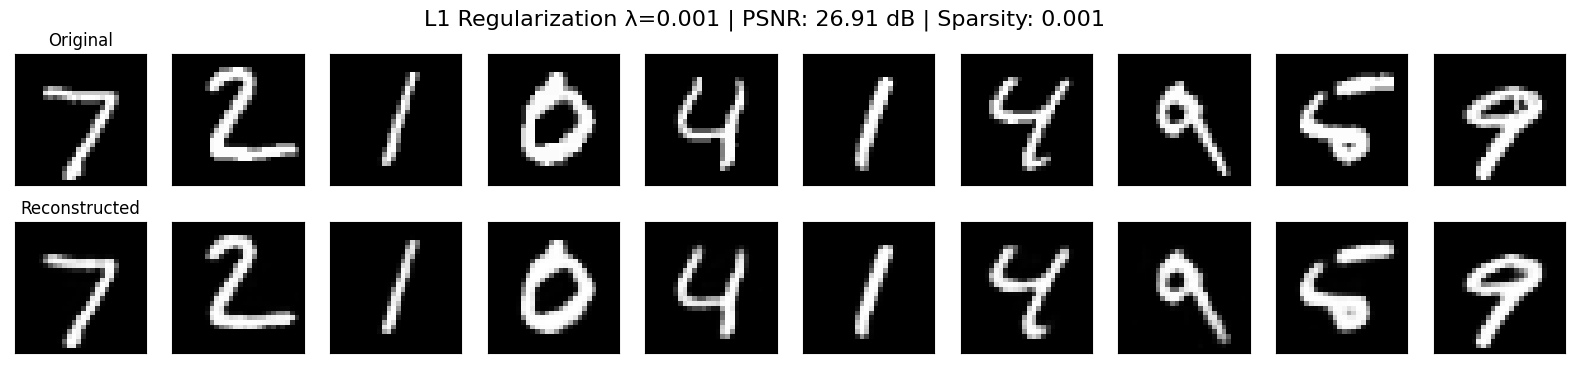

Final Test PSNR: 26.91 dB
Sparsity Ratio: 0.001
Mean Activation: 0.7484

--- Training with λ_L1 = 0.01 ---
Using device: cuda


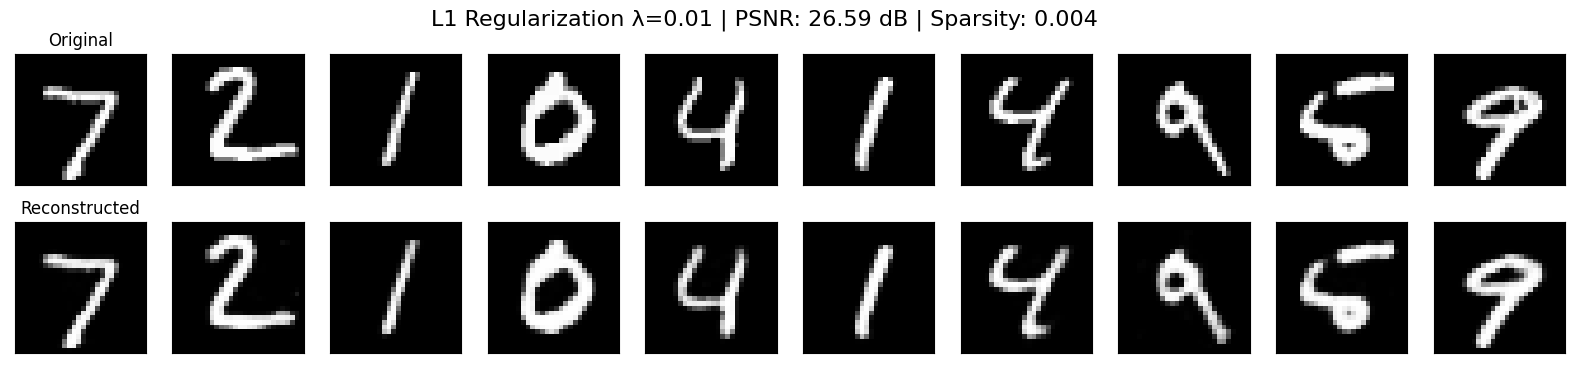

Final Test PSNR: 26.59 dB
Sparsity Ratio: 0.004
Mean Activation: 0.2156

--- Training with λ_L1 = 0.1 ---
Using device: cuda


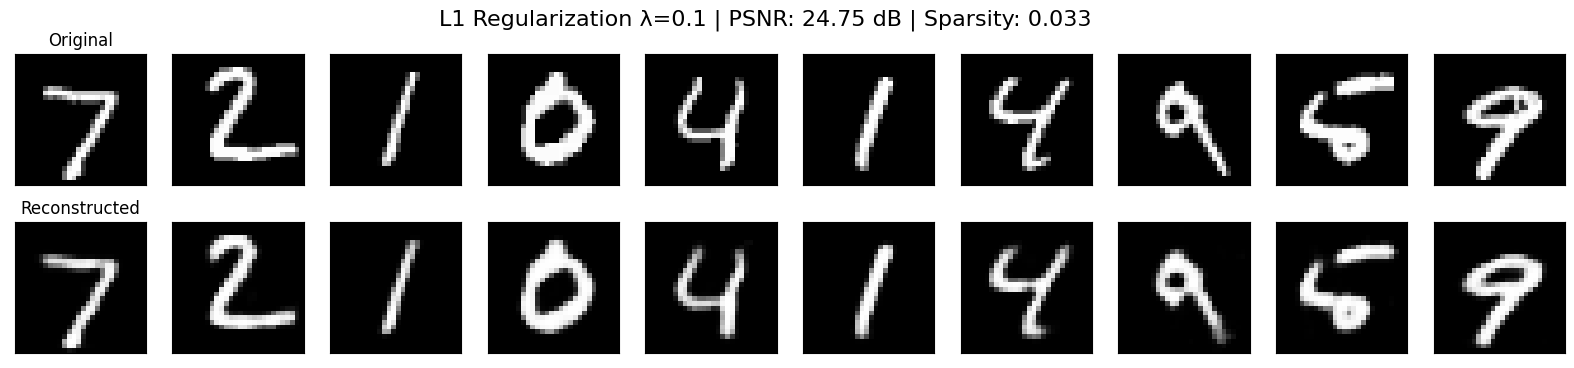

Final Test PSNR: 24.75 dB
Sparsity Ratio: 0.033
Mean Activation: 0.0454

--- Training with λ_L1 = 0.2 ---
Using device: cuda


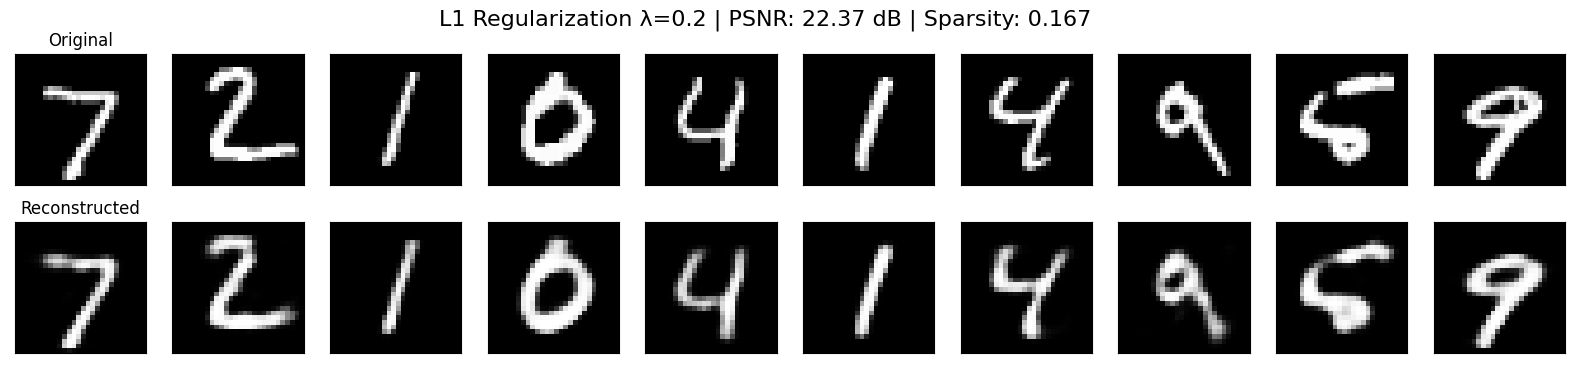

Final Test PSNR: 22.37 dB
Sparsity Ratio: 0.167
Mean Activation: 0.0238


In [26]:
# Test different L1 regularization values
lambda_l1_values = [0.0, 0.001, 0.01, 0.1, 0.2]
results_l1 = []

# Use MNIST for this experiment (you can change to FMNIST if preferred)
train_loader = mnist_train_loader
test_loader = mnist_test_loader

# Best experimental parameters
BEST_LATENT = 100
BEST_NUM_LAY = 3

for i, lambda_l1 in enumerate(lambda_l1_values):
    print(f"\n--- Training with λ_L1 = {lambda_l1} ---")
    
    # Initialize model with best architecture (3 layers, 50 latent dim)
    model = Extended_Autoencoder(input_dim=INPUT_DIM, latent_dim=BEST_LATENT,
                                 num_layers=BEST_NUM_LAY, epoch=NUM_EPOCHS,
                                 l1=lambda_l1)
    
    # Train model
    model.train_loop(train_loader, validate=True, val_dataloader=test_loader)

    # Test model
    model.eval_loop(test_loader)

    # Analyze sparsity
    sparsity_metrics = model.analyze_sparsity(test_loader)

    # Store results
    result = {
        'lambda_l1': lambda_l1,
        'final_test_loss': model.loss_during_test,
        'final_test_psnr': model.psnr_during_test,
        'sparsity_ratio': sparsity_metrics['sparsity_ratio'],
        'mean_activation': sparsity_metrics['mean_activation'],
        'latent_std': sparsity_metrics['latent_std']
    }
    results_l1.append(result)
    
    # Visualize results for this model
    data, _ = next(iter(test_loader))
    recon, _ = model(data.to(model.device))
    plot_reconstructions(data.cpu(), recon.cpu().detach(),
                        title=f"L1 Regularization λ={lambda_l1} | PSNR: {results_l1[i]['final_test_psnr']:.2f} dB | Sparsity: {results_l1[i]['sparsity_ratio']:.3f}")
    
    
    print(f"Final Test PSNR: {model.psnr_during_test:.2f} dB")
    print(f"Sparsity Ratio: {sparsity_metrics['sparsity_ratio']:.3f}")
    print(f"Mean Activation: {sparsity_metrics['mean_activation']:.4f}")


--- L1 Regularization Results Summary ---
 lambda_l1  final_test_loss  final_test_psnr  sparsity_ratio  mean_activation  latent_std
    0.0000           0.0680          26.7445          0.0005           1.6189      2.0475
    0.0010           0.0678          26.9054          0.0009           0.7484      0.9624
    0.0100           0.0684          26.5941          0.0035           0.2156      0.2899
    0.1000           0.0730          24.7452          0.0334           0.0454      0.0752
    0.2000           0.0828          22.3705          0.1667           0.0238      0.0466


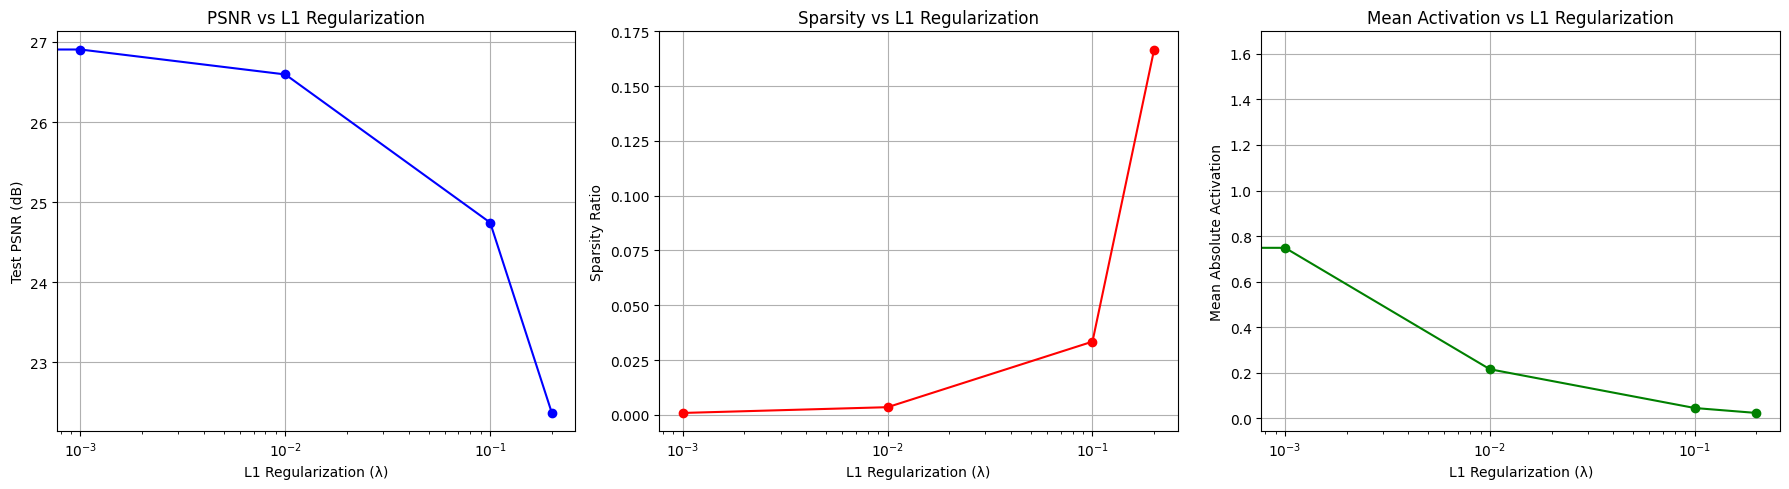

In [27]:
# --- Results Analysis (L1 Regularization) ---
print("\n--- L1 Regularization Results Summary ---")
results_l1_df = pd.DataFrame(results_l1)
print(results_l1_df.to_string(index=False, float_format='%.4f'))

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PSNR vs L1 lambda
axes[0].plot([r['lambda_l1'] for r in results_l1], 
             [r['final_test_psnr'] for r in results_l1], 'bo-')
axes[0].set_xlabel('L1 Regularization (λ)')
axes[0].set_ylabel('Test PSNR (dB)')
axes[0].set_title('PSNR vs L1 Regularization')
axes[0].set_xscale('log')
axes[0].grid(True)

# Sparsity vs L1 lambda
axes[1].plot([r['lambda_l1'] for r in results_l1 if r['lambda_l1'] > 0], 
             [r['sparsity_ratio'] for r in results_l1 if r['lambda_l1'] > 0], 'ro-')
axes[1].set_xlabel('L1 Regularization (λ)')
axes[1].set_ylabel('Sparsity Ratio')
axes[1].set_title('Sparsity vs L1 Regularization')
axes[1].set_xscale('log')
axes[1].grid(True)

# Mean activation vs L1 lambda
axes[2].plot([r['lambda_l1'] for r in results_l1], 
             [r['mean_activation'] for r in results_l1], 'go-')
axes[2].set_xlabel('L1 Regularization (λ)')
axes[2].set_ylabel('Mean Absolute Activation')
axes[2].set_title('Mean Activation vs L1 Regularization')
axes[2].set_xscale('log')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## 4. Part 2: Denoising Autoencoder (DAE)

We now use the "best" architecture (e.g., 5-layer, 50-dim) to build a DAE.


### 4.1. DAE Training and Evaluation Loops

The model class is the same (Autoencoder), but the training and evaluation loops change:
- **train_dae_epoch:** Feeds a noisy image to the model but computes the loss against the original image.
- **eval_dae_epoch:** Does the same, and also calculates PSNR of (noisy vs. original) and (denoised vs. original) for comparison.


In [28]:
def plot_denoising(originals, noisy, denoised, n=10, title="Denoising Results"):
    """Plots original, noisy, and denoised images."""
    plt.figure(figsize=(20, 6))
    plt.suptitle(title, fontsize=16)
    for i in range(n):
        # Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(originals[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0: ax.set_title("Original")

        # Noisy
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0: ax.set_title("Noisy")

        # Denoised
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0: ax.set_title("Denoised")
    plt.show()


### 4.2. Experiment 3: DAE Performance vs. Noise Variance

We train a separate DAE for each noise level and analyze the performance.


--- Starting Experiment 3: DAE Performance vs. Noise Variance ---
Testing DAE: MNIST | Noise Variance: 0.01
Using device: cuda


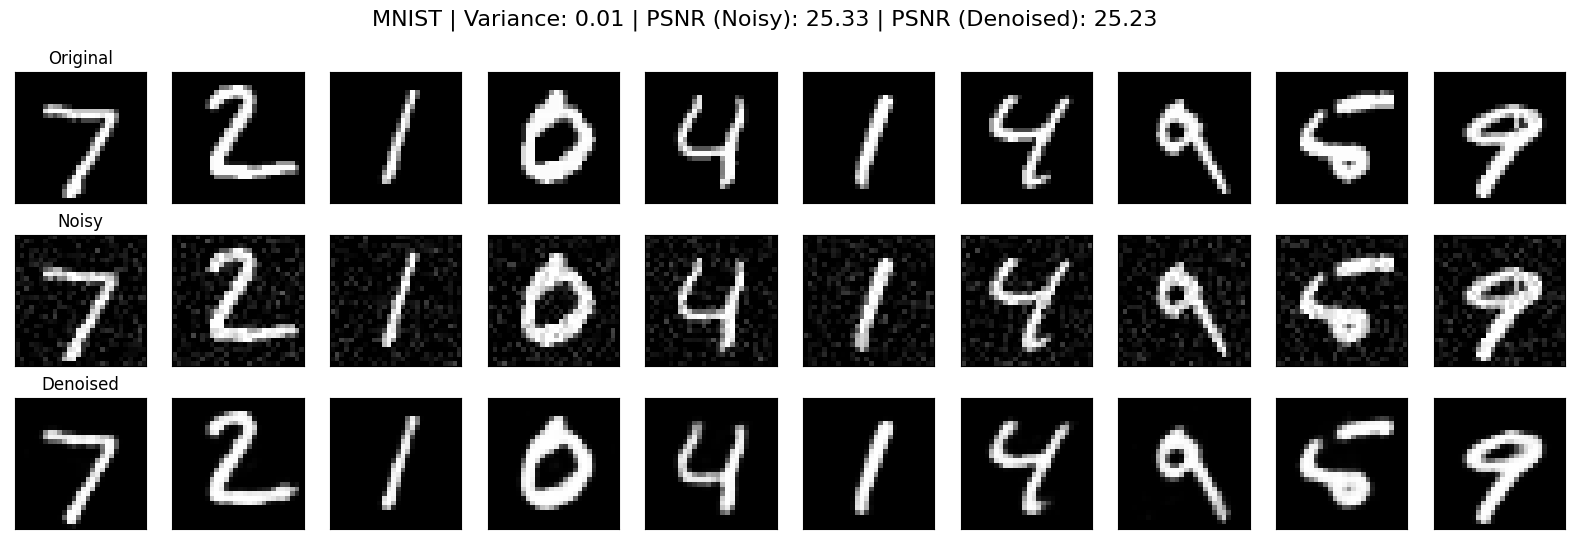

Testing DAE: MNIST | Noise Variance: 0.05
Using device: cuda


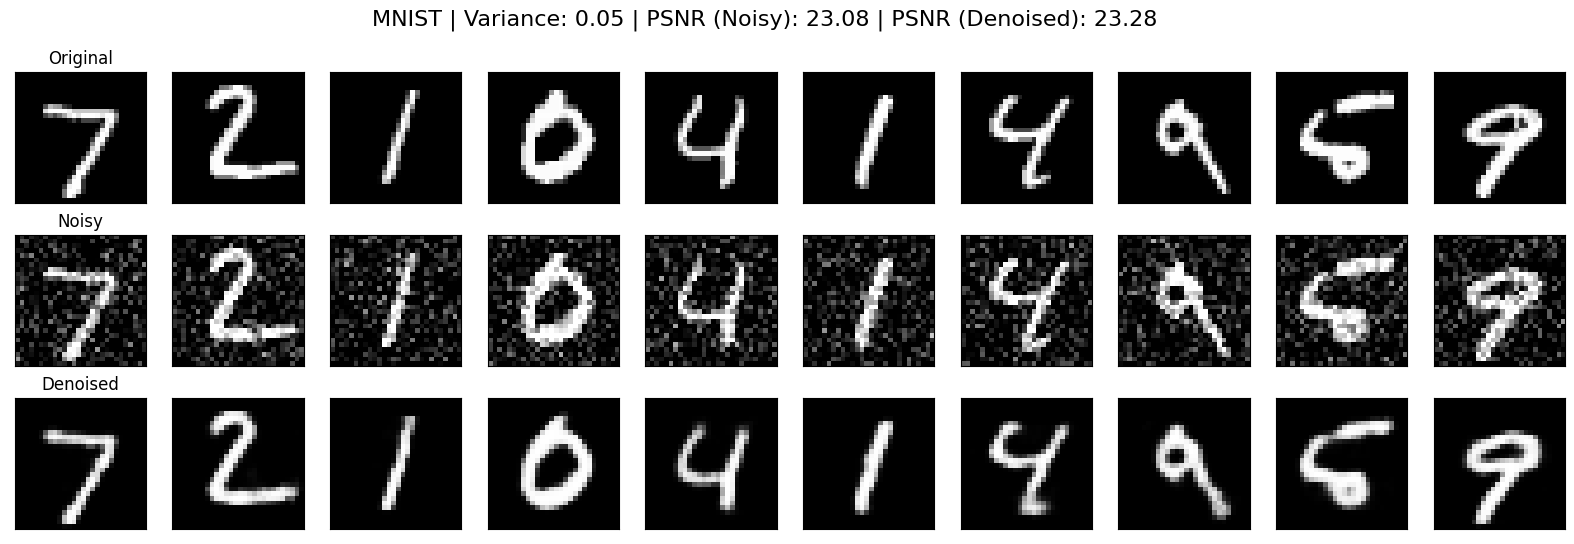

Testing DAE: MNIST | Noise Variance: 0.1
Using device: cuda


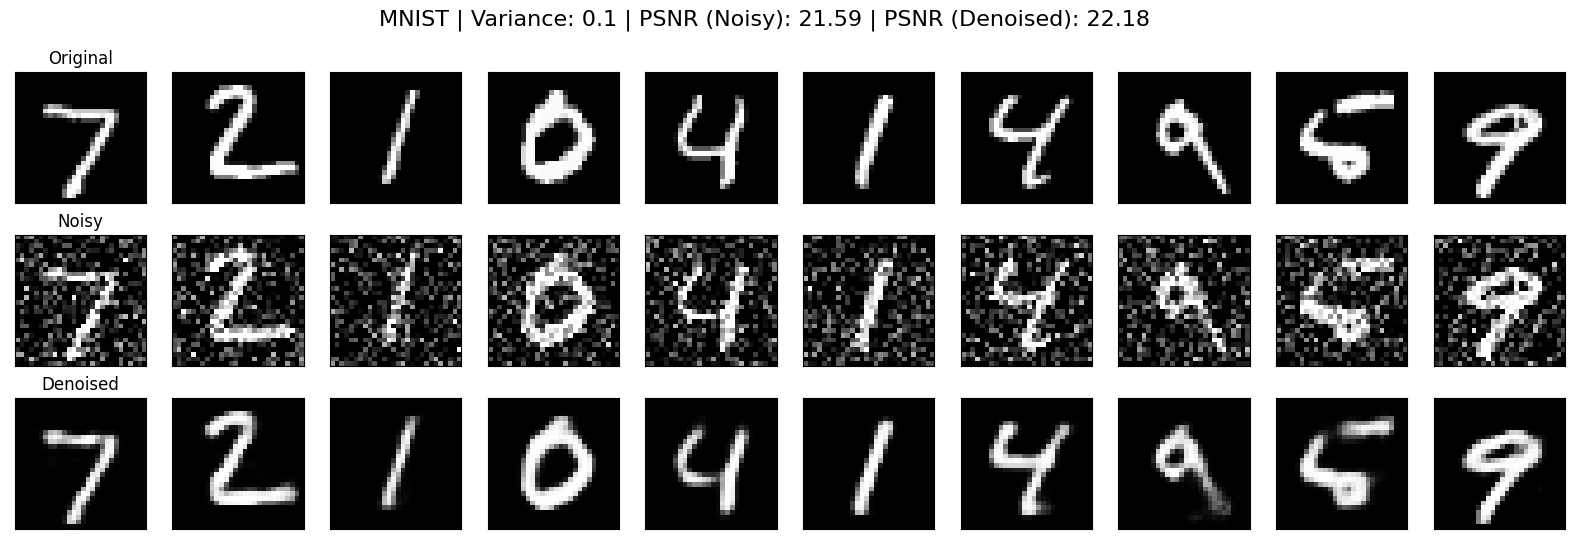

Testing DAE: MNIST | Noise Variance: 0.2
Using device: cuda


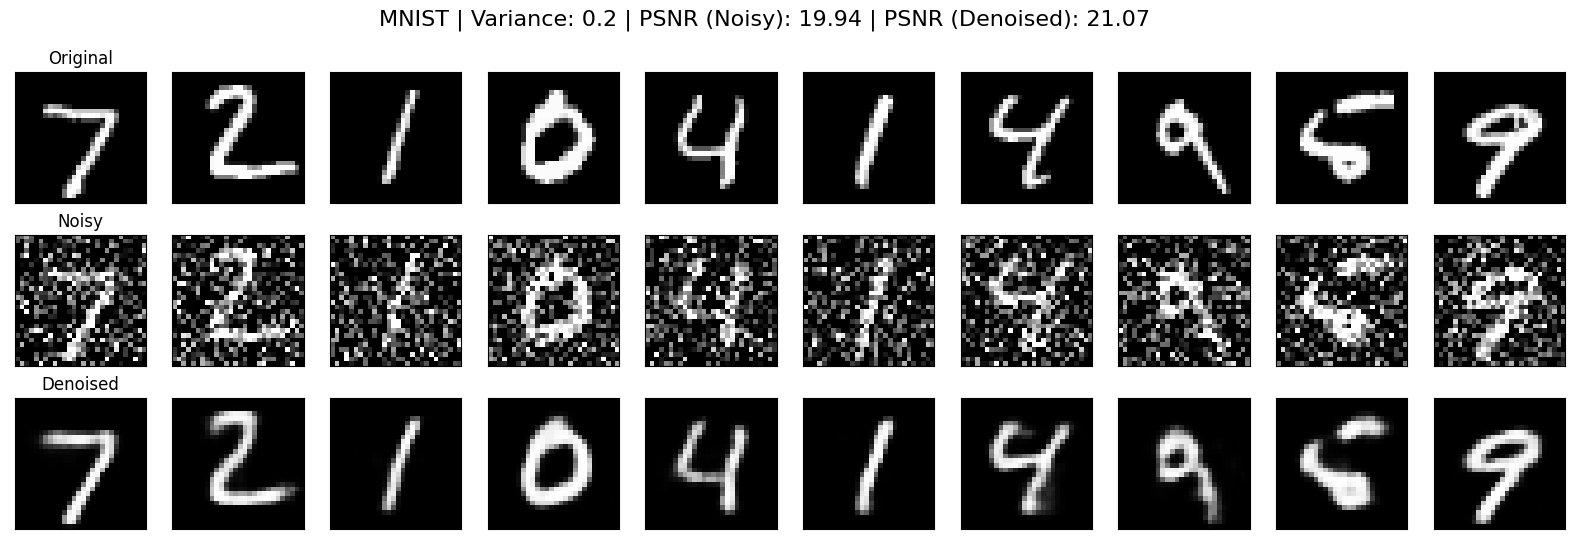

Testing DAE: FMNIST | Noise Variance: 0.01
Using device: cuda


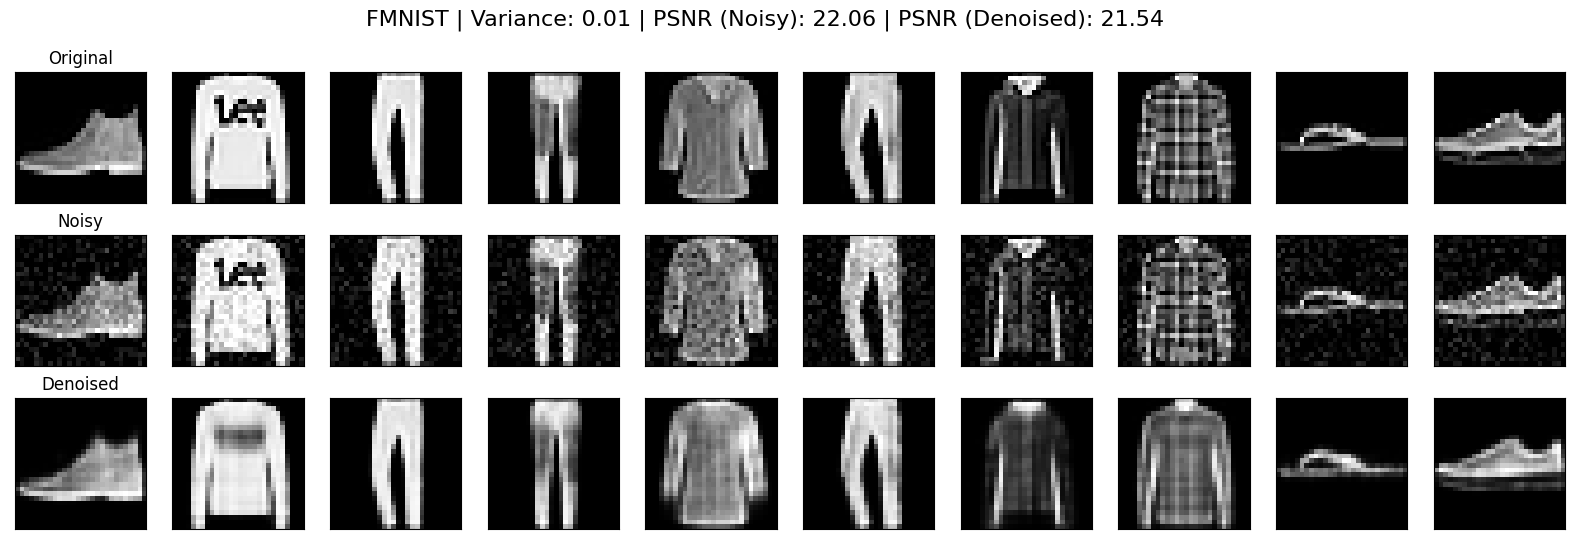

Testing DAE: FMNIST | Noise Variance: 0.05
Using device: cuda


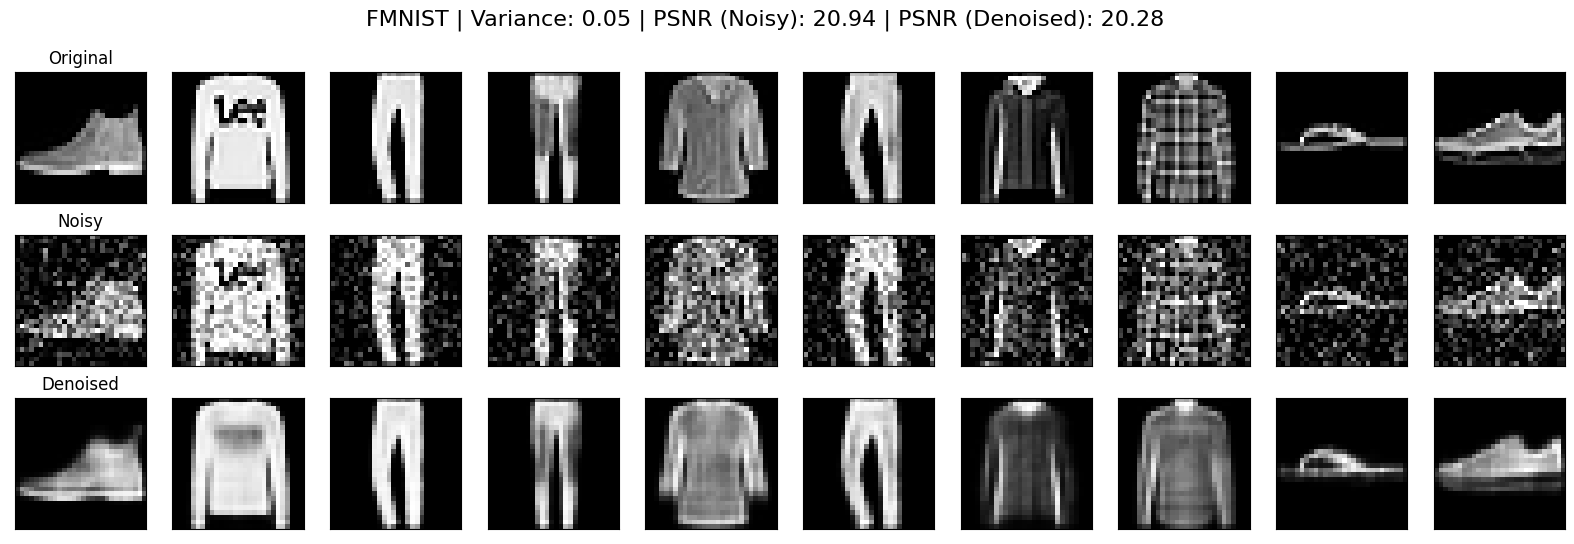

Testing DAE: FMNIST | Noise Variance: 0.1
Using device: cuda


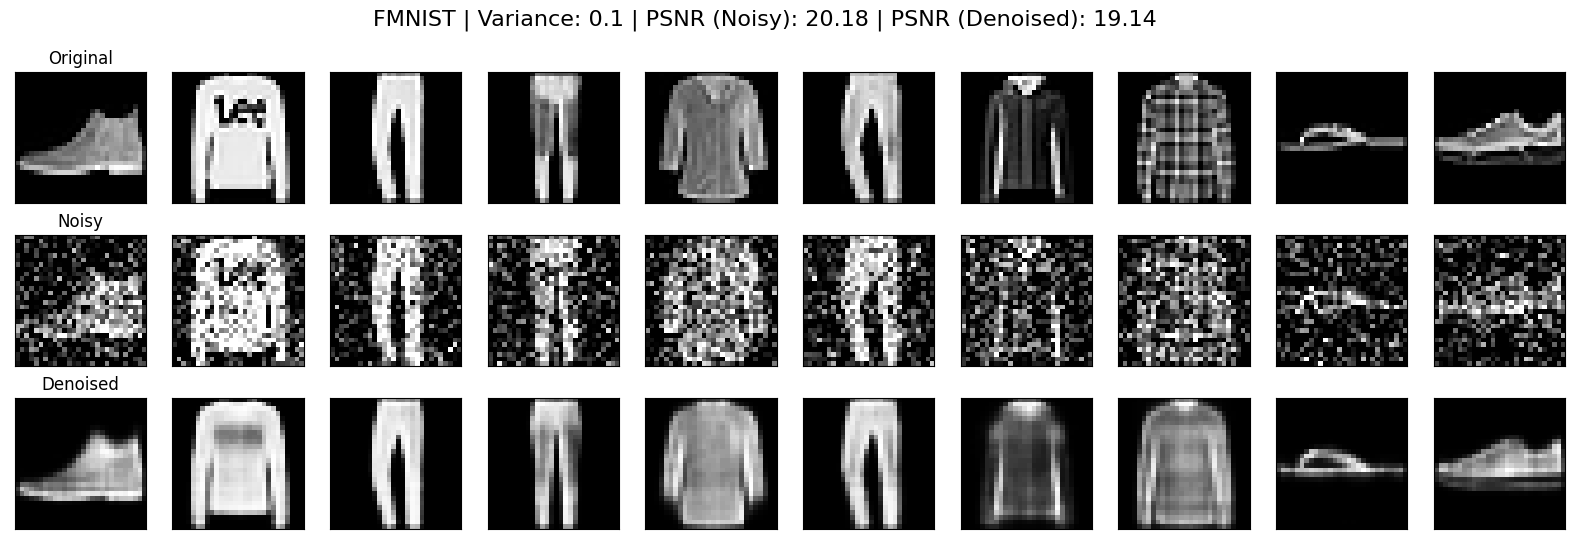

Testing DAE: FMNIST | Noise Variance: 0.2
Using device: cuda


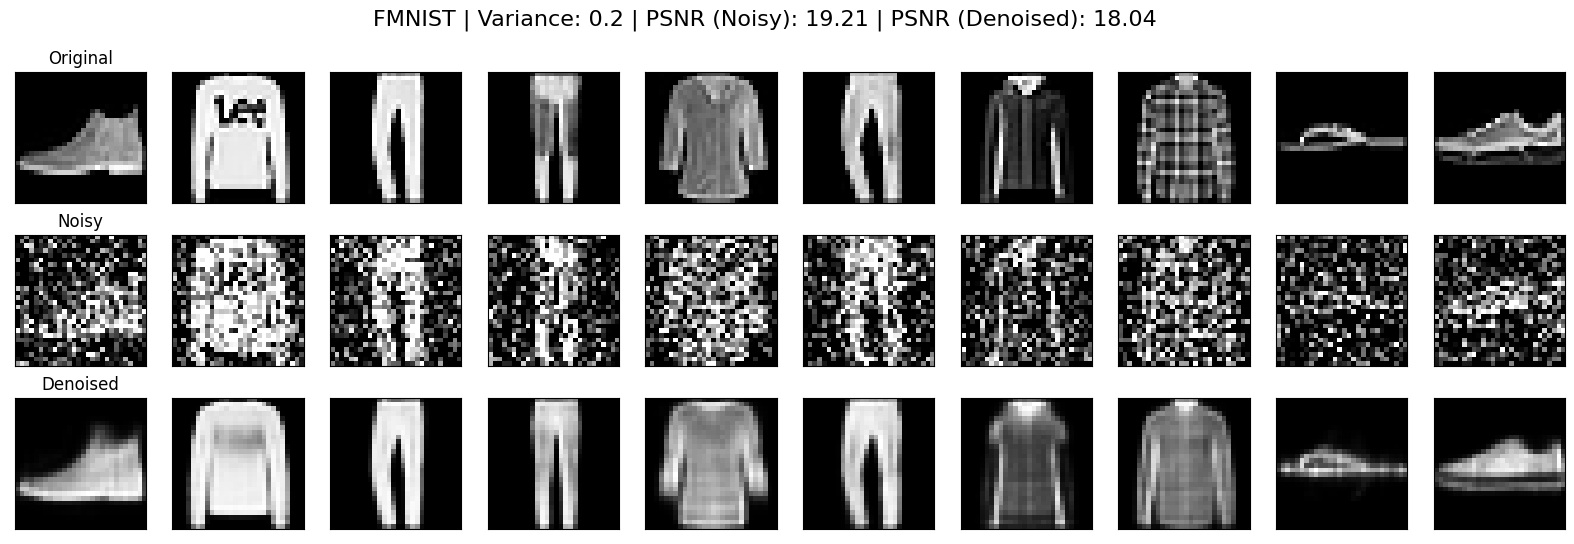

In [39]:
# --- Placeholder for Experiment 3 ---
print("\n--- Starting Experiment 3: DAE Performance vs. Noise Variance ---")

noise_variances = [0.01, 0.05, 0.1, 0.2] # Tunable variances
dae_results = []
DAE_EPOCHS = 10 # (Adjust as needed)

for d_name, (train_loader, test_loader) in datasets_to_test.items():
    for variance in noise_variances:
        print(f"Testing DAE: {d_name} | Noise Variance: {variance}")

        # We must train a new model for each noise level
        # Using the "best" architecture identified in Part 1 (3 layers, 100 latent dim)
        model_dae = Extended_Autoencoder(input_dim=INPUT_DIM, 
                                         latent_dim=BEST_LATENT, 
                                         num_layers=BEST_NUM_LAY, epoch=NUM_EPOCHS)
        
        # train the model with the selected gaussian noise
        model_dae.train_loop(train_loader, add_gaussian_noise=True, noise_var=variance)

        # Evaluate the model with the test set adding gaussian noise
        model_dae.eval_loop(test_loader, add_gaussian_noise=True, noise_var=variance)
        
        # Save the results
        dae_results.append({
            "Dataset": d_name,
            "Noise Variance": variance,
            "PSNR (Noisy)": model_dae.psnr_during_noise_test,
            "PSNR (Denoised)": model_dae.psnr_during_test,
            # denoised - Noise results of PSNR
            "PSNR Improvement": model_dae.psnr_during_test - model_dae.psnr_during_noise_test
        })

        # Visualize results
        data, _ = next(iter(test_loader))
        noisy_data = model_dae.add_gaussian_noise_(data, variance)
        recon_data, _ = model_dae(noisy_data.to(model_dae.device))

        plot_denoising(data.cpu(), noisy_data.cpu(), recon_data.cpu().detach(),
                       title=f"{d_name} | Variance: {variance} | PSNR (Noisy): {model_dae.psnr_during_noise_test:.2f} | PSNR (Denoised): {model_dae.psnr_during_test:.2f}")

| Dataset   |   Noise Variance |   PSNR (Noisy) |   PSNR (Denoised) |   PSNR Improvement |
|:----------|-----------------:|---------------:|------------------:|-------------------:|
| MNIST     |             0.01 |        25.3271 |           25.2339 |         -0.0931559 |
| MNIST     |             0.05 |        23.0767 |           23.2799 |          0.20317   |
| MNIST     |             0.1  |        21.5866 |           22.1822 |          0.595612  |
| MNIST     |             0.2  |        19.9376 |           21.0727 |          1.13513   |
| FMNIST    |             0.01 |        22.0605 |           21.5359 |         -0.524535  |
| FMNIST    |             0.05 |        20.9372 |           20.2831 |         -0.65414   |
| FMNIST    |             0.1  |        20.1811 |           19.1447 |         -1.03639   |
| FMNIST    |             0.2  |        19.2108 |           18.0354 |         -1.17541   |


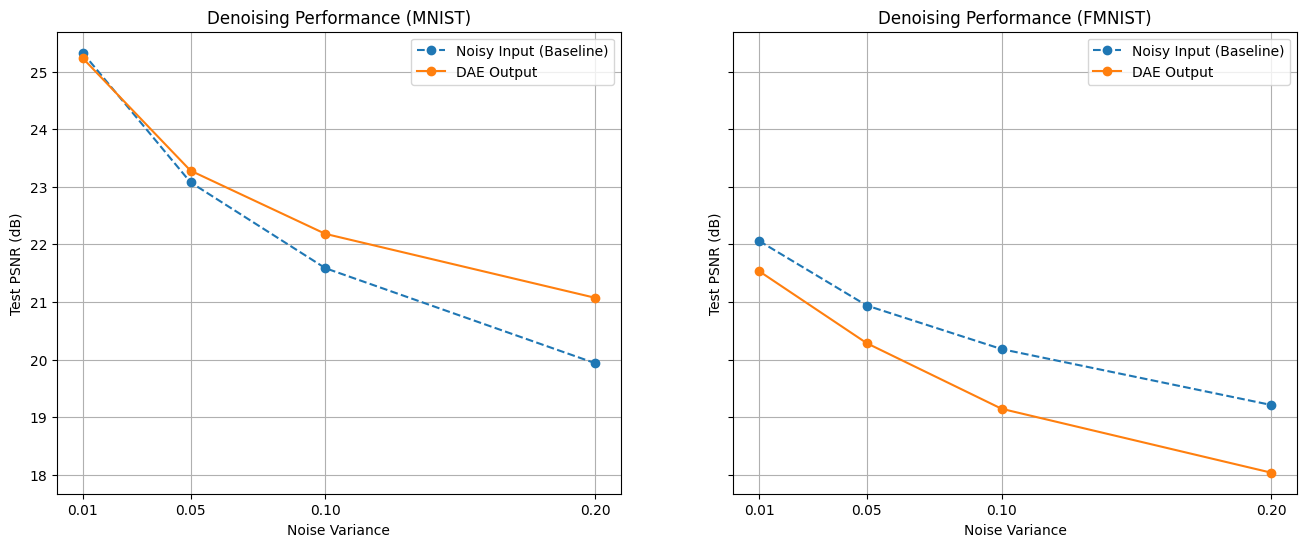

In [40]:
# --- Results Analysis (Exp 3) ---
dae_results_df = pd.DataFrame(dae_results)
print(dae_results_df.to_markdown(index=False))

# Plot summary graphs
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
for i, d_name in enumerate(datasets_to_test.keys()):
    ax = axes[i]
    subset = dae_results_df[dae_results_df['Dataset'] == d_name]
    ax.plot(subset['Noise Variance'], subset['PSNR (Noisy)'], 'o--', label='Noisy Input (Baseline)')
    ax.plot(subset['Noise Variance'], subset['PSNR (Denoised)'], 'o-', label='DAE Output')
    ax.set_title(f"Denoising Performance ({d_name})")
    ax.set_xlabel("Noise Variance")
    ax.set_ylabel("Test PSNR (dB)")
    ax.set_xticks(noise_variances)
    ax.legend()
    ax.grid(True)
plt.show()

## 5. Conclusion

This final section summarizes the key findings from all three experiments, addressing the initial project goals.
- **Architecture:** Briefly summarize which performed better (3-layer vs. 5-layer) and why (e.g., “The 5-layer model consistently outperformed the 3-layer model, suggesting the added capacity was beneficial...”).
- **Latent Dimension:** Discuss the impact of the latent dimension (e.g., “PSNR improved up to a dimension of 50, after which performance plateaued...”).
- **\(L_1\) Regularization:** Explain its effect (e.g., “Applying \(L_1\) regularization successfully induced sparsity in the latent space... This came at a minor cost to reconstruction PSNR...”).
- **Denoising:** Conclude on the DAE's effectiveness (e.g., “The DAE significantly improved PSNR across all tested noise levels... As noise variance increased, the absolute PSNR dropped, but the relative improvement over the noisy input became more pronounced.”).